In [2]:
# Import necessary libraries
import pandas as pd

# Load the dataset
# Make sure to adjust the file path if needed
df = pd.read_csv('idp dataset 15 (final).csv')

# Assuming you have a column 'averageRating' that holds the ratings, and you want to map them to sentiments
def get_sentiment(rating):
    # Map ratings to sentiment
    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

# Convert 'averageRating' column to numeric (in case of non-numeric values)
df['averageRating'] = pd.to_numeric(df['averageRating'], errors='coerce')

# Create the target sentiment column based on ratings
df['sentiment'] = df['averageRating'].apply(get_sentiment)

# Drop rows with missing sentiment values (if any)
df = df.dropna(subset=['sentiment'])

# Display the first few rows to ensure everything is correct
print(df[['averageRating', 'sentiment']].head())


   averageRating sentiment
0            4.3  positive
1            4.3  positive
2            4.3  positive
3            4.3  positive
4            4.3  positive


In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Import necessary libraries for tokenization
import nltk
nltk.download('punkt')  # Download the necessary tokenizer resources
from nltk.tokenize import word_tokenize

# Assuming 'reviewText' is the column with the original review text
# Tokenize the reviews
df['tokenizedReview'] = df['reviewDescription'].apply(lambda x: word_tokenize(x.lower()))  # Convert text to lowercase and tokenize

# Check the tokenized output
print(df[['reviewDescription', 'tokenizedReview']].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\HP/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\HP\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:
# Import libraries for cleaning
import nltk
nltk.download('stopwords')  # Download stopwords list
from nltk.corpus import stopwords
import string

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Function to clean tokenized reviews
def clean_tokens(tokens):
    cleaned_tokens = []
    for token in tokens:
        # Remove stopwords and punctuation, and ensure the token is alphabetic
        if token not in stop_words and token not in punctuation and token.isalpha():
            cleaned_tokens.append(token)
    return cleaned_tokens

# Apply the cleaning function to the tokenized reviews
df['cleanedReview'] = df['tokenizedReview'].apply(clean_tokens)

# Check the cleaned reviews
print(df[['tokenizedReview', 'cleanedReview']].head())


  tokenizedReview   cleanedReview
0  [unbelievable]  [unbelievable]
1  [good, mobile]  [good, mobile]
2          [good]          [good]
3  [it, 's, good]          [good]
4    [very, nice]          [nice]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Rebuild the cleaned tokens back into a single string for Bag of Words
df['reviewText'] = df['cleanedReview'].apply(lambda tokens: ' '.join(tokens))

# Check the final text before vectorization
print(df[['cleanedReview', 'reviewText']].head())


    cleanedReview    reviewText
0  [unbelievable]  unbelievable
1  [good, mobile]   good mobile
2          [good]          good
3          [good]          good
4          [nice]          nice


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Assuming df['reviewText'] contains the text reviews and df['sentiment'] contains target labels

# Step 1: Bag of Words Feature Extraction
bow_vectorizer = CountVectorizer(max_features=1000)  # Limit to 1000 features for simplicity
X_bow = bow_vectorizer.fit_transform(df['reviewText']).toarray()

# Step 2: Word Embedding (Word2Vec)

# Tokenizing the reviews for Word Embedding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['reviewText'])
X_tokenized = tokenizer.texts_to_sequences(df['reviewText'])

# Pad sequences to ensure equal length for all reviews
max_len = 100  # Define max length for padding
X_padded = pad_sequences(X_tokenized, maxlen=max_len)

# Train a Word2Vec model or load pre-trained word embeddings (e.g., GloVe)
# Here, let's train a Word2Vec model (you can use GloVe if available)
embedding_dim = 100  # Define the embedding dimension size
word2vec_model = Word2Vec(sentences=tokenizer.texts_to_sequences(df['reviewText']), vector_size=embedding_dim, window=5, min_count=1)

# Create an embedding matrix for the word index in the text
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Step 3: Combining BoW and Word Embedding Features

# Bag of Words is already in X_bow
# Word Embeddings are now in X_padded (sequence of word indices)

# We need to average the word embeddings for each sequence (to get a fixed-size representation per review)
def average_word_embeddings(padded_sequences, embedding_matrix):
    averaged_embeddings = []
    for sequence in padded_sequences:
        valid_embeddings = [embedding_matrix[idx] for idx in sequence if idx != 0]  # Skip padding tokens
        if valid_embeddings:
            averaged_embeddings.append(np.mean(valid_embeddings, axis=0))
        else:
            averaged_embeddings.append(np.zeros(embedding_matrix.shape[1]))  # Append zeros for empty reviews
    return np.array(averaged_embeddings)

X_word_embeddings = average_word_embeddings(X_padded, embedding_matrix)

# Concatenating BoW and Word Embeddings
X_hybrid = np.hstack((X_bow, X_word_embeddings))

# Step 4: Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, df['sentiment'], test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

Training samples: 539, Test samples: 135


In [ ]:
# Import necessary libraries for building ANN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical # Import to_categorical
from sklearn.preprocessing import LabelEncoder


# Step 4: Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, df['sentiment'], test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Convert sentiment labels to numerical using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# One-hot encode the target variable
y_train = to_categorical(y_train, num_classes=3) # Assuming 3 sentiment classes: positive, negative, neutral
y_test = to_categorical(y_test, num_classes=3)

# Build the ANN Model
model = Sequential()

# Input Layer (size = BoW features + embedding_dim)
input_dim = X_hybrid.shape[1]  # Total number of combined features
model.add(Dense(256, input_dim=input_dim, activation='relu'))

# Hidden Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization

model.add(Dense(64, activation='relu'))

# Output Layer (assuming sentiment is a classification task with 3 classes: positive, negative, neutral)
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100}")

Training samples: 539, Test samples: 135


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7461 - loss: 0.8984 - val_accuracy: 0.9333 - val_loss: 0.4477
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8955 - loss: 0.4734 - val_accuracy: 0.9333 - val_loss: 0.3392
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9156 - loss: 0.2691 - val_accuracy: 0.9333 - val_loss: 0.2764
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8838 - loss: 0.2779 - val_accuracy: 0.9333 - val_loss: 0.2341
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9105 - loss: 0.1939 - val_accuracy: 0.9407 - val_loss: 0.2040
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9512 - loss: 0.1611 - val_accuracy: 0.9481 - val_loss: 0.2012
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9676 - loss: 0.1253 - val_accuracy: 0.9481 - val_loss: 0.2124
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9714 - loss: 0.1007 - val_accuracy: 0.9481 - val_los

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test Accuracy: 0.9481
Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.33      0.46         9
    positive       0.95      0.99      0.97       126

    accuracy                           0.95       135
   macro avg       0.85      0.66      0.72       135
weighted avg       0.94      0.95      0.94       135

Confusion Matrix:
[[  3   6]
 [  1 125]]


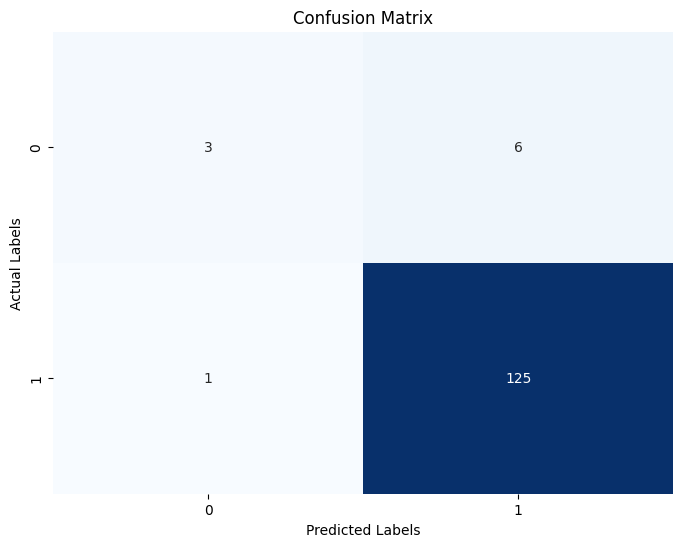

In [ ]:
# Import libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Since we are dealing with multi-class classification (positive, neutral, negative),
# Convert the true labels (y_test) back to integer format if necessary
y_test_int = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_int, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test_int, y_pred, target_names=['negative', 'positive'])) # Change this line

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_int, y_pred)) # Change this line

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming you have your predicted values and actual values
# y_test = the actual labels from the test set
# y_pred = the predicted labels from your model

# Calculate the confusion matrix
cm = confusion_matrix(y_test_int, y_pred) # Change this line

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [ ]:
# Function to predict sentiment for new reviews
def predict_sentiment(new_reviews, bow_vectorizer, tokenizer, embedding_matrix, model, max_len=100):
    # Step 1: Clean and process the new reviews similar to the original data
    new_reviews_bow = bow_vectorizer.transform(new_reviews).toarray()  # BoW vector

    # Step 2: Tokenize and pad the new reviews for embedding
    new_reviews_tokenized = tokenizer.texts_to_sequences(new_reviews)
    new_reviews_padded = pad_sequences(new_reviews_tokenized, maxlen=max_len)

    # Step 3: Average the word embeddings for each review
    new_reviews_embeddings = average_word_embeddings(new_reviews_padded, embedding_matrix)

    # Step 4: Combine BoW and embeddings into a hybrid feature vector
    new_reviews_hybrid = np.hstack((new_reviews_bow, new_reviews_embeddings))

    # Step 5: Make predictions using the trained model
    predictions = model.predict(new_reviews_hybrid)

    # Convert probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    return predicted_labels

# Example usage with new reviews
new_reviews = ["This product is amazing!", "I had a terrible experience.", "It was just okay, nothing special."]
predicted_sentiments = predict_sentiment(new_reviews, bow_vectorizer, tokenizer, embedding_matrix, model)

# Print the predicted sentiments
label_mapping = {0: 'negative', 1: 'positive'}
predicted_sentiments_labels = [label_mapping[label] for label in predicted_sentiments]
print(predicted_sentiments_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
['positive', 'positive', 'positive']


XGBoost Accuracy: 0.9259
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.97      0.95      0.96       126

    accuracy                           0.93       135
   macro avg       0.71      0.75      0.73       135
weighted avg       0.93      0.93      0.93       135

XGBoost Confusion Matrix:
[[  5   4]
 [  6 120]]


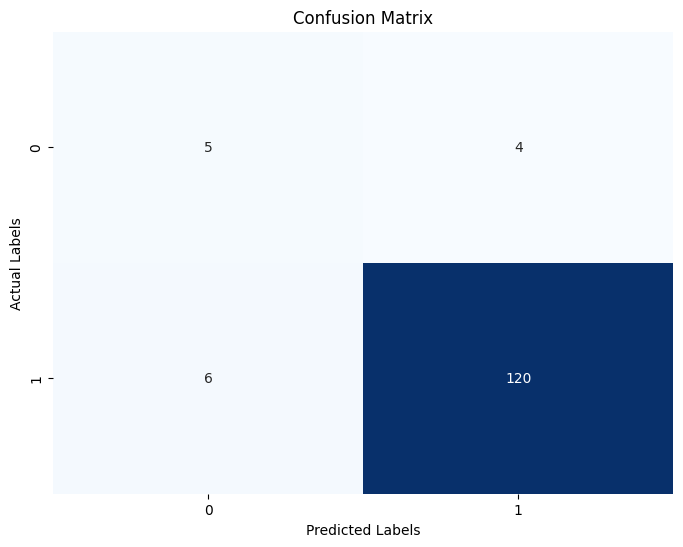

In [ ]:
# Import necessary libraries for XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np  # Import numpy

# Initialize the XGBoost classifier
xgb_model = XGBClassifier()

# Train the model on the training set (using integer labels for y_train)
xgb_model.fit(X_train, np.argmax(y_train, axis=1)) # Convert y_train to integer labels

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model (using integer labels for y_test)
print(f"XGBoost Accuracy: {accuracy_score(np.argmax(y_test, axis=1), y_pred_xgb):.4f}") # Convert y_test to integer labels
print("XGBoost Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_xgb)) # Convert y_test to integer labels
print("XGBoost Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_xgb)) # Convert y_test to integer labels

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_xgb)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.9481
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.96      0.98      0.97       126

    accuracy                           0.95       135
   macro avg       0.81      0.71      0.75       135
weighted avg       0.94      0.95      0.94       135

AdaBoost Confusion Matrix:
[[  4   5]
 [  2 124]]


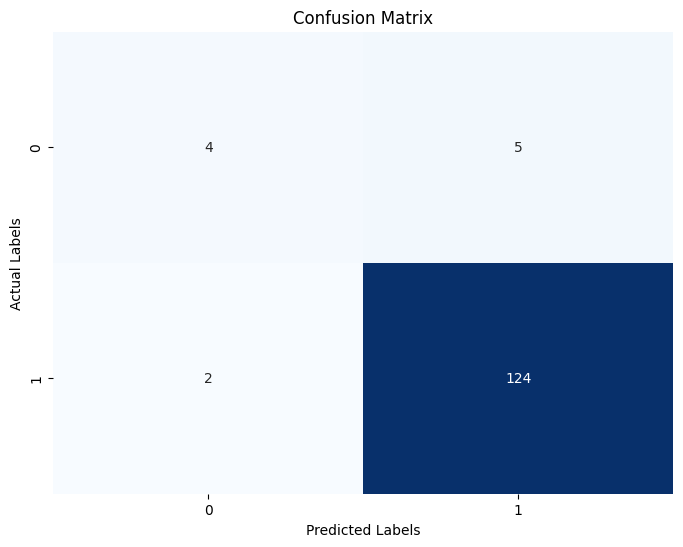

In [ ]:
# Import necessary libraries for AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np # Import numpy

# Initialize a Decision Tree as the base estimator for AdaBoost
base_estimator = DecisionTreeClassifier(max_depth=1)

# Initialize the AdaBoost classifier
# Use 'estimator' instead of 'base_estimator'
ada_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0)

# Train the AdaBoost model on the training set
# Convert y_train back to a 1D array of class labels using argmax
ada_model.fit(X_train, np.argmax(y_train, axis=1))

# Make predictions on the test set
y_pred_ada = ada_model.predict(X_test)

# Evaluate the model
# Convert y_test back to a 1D array of class labels using argmax for evaluation
print(f"AdaBoost Accuracy: {accuracy_score(np.argmax(y_test, axis=1), y_pred_ada):.4f}")
print("AdaBoost Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_ada))
print("AdaBoost Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_ada))

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_ada)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 485, number of negative: 54
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 55
[LightGBM] [Info] Number of data points in the train set: 539, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.899814 -> initscore=2.195165
[LightGBM] [Info] Start training from score 2.195165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

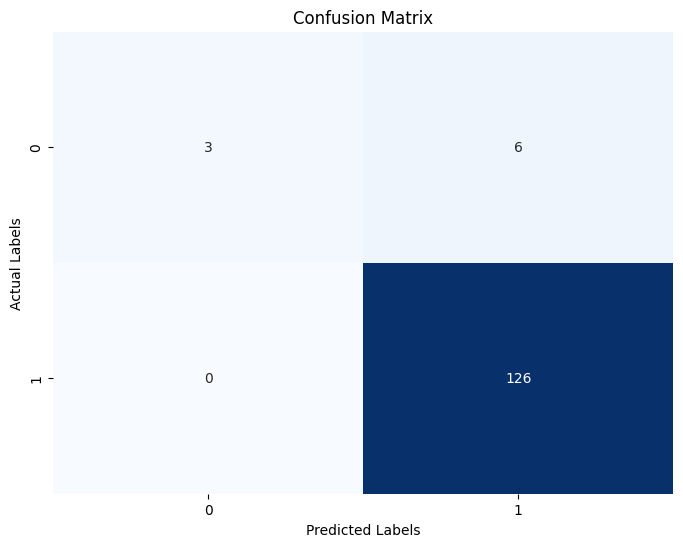

In [ ]:
# Import necessary libraries
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np # Import numpy

# Step 1: Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Step 2: Initialize Gradient Boosting Machine (GBM) model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3)

# Step 3: Create a Voting Classifier (soft voting for probability-based averaging)
voting_model = VotingClassifier(estimators=[('lightgbm', lgb_model), ('gbm', gbm_model)], voting='soft')

# Step 4: Train the Voting Classifier on the training data
# Convert y_train to a 1D array of class labels using argmax
voting_model.fit(X_train, np.argmax(y_train, axis=1))

# Step 5: Make predictions on the test set
y_pred_voting = voting_model.predict(X_test)

# Step 6: Evaluate the model
# Convert y_test to a 1D array of class labels using argmax for evaluation
print(f"Voting Classifier Accuracy: {accuracy_score(np.argmax(y_test, axis=1), y_pred_voting):.4f}")
print("Voting Classifier Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred_voting))
print("Voting Classifier Confusion Matrix:")
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred_voting))

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_voting)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


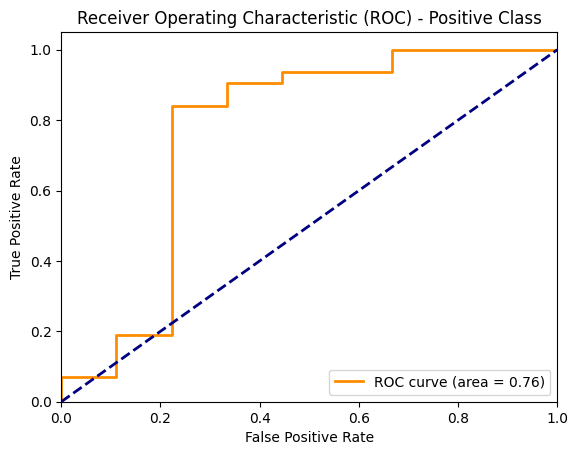

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.preprocessing import label_binarize # Import label_binarize

# Assuming 'ann_model' is your trained ANN model
# Predict the probabilities for each class
y_score_ann = model.predict(X_test)

# Get the probabilities for the positive class (assuming class 1 is positive)
y_score_positive = y_score_ann[:, 1]

# Binarize the true labels for the positive class (assuming class 1 is positive)
y_test_positive = y_test[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test_positive, y_score_positive)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Positive Class')
plt.legend(loc="lower right")
plt.show()